<a href="https://colab.research.google.com/github/GuillermoSainz07/Notebooks-DS/blob/main/Prediccion_de_volatilidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediccion de volatilidad

In [ ]:
!pip install yfinance

In [ ]:
!pip install arch

In [ ]:
plt.style.use('seaborn')

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
stock = '^GSPC'
sp_500 = yf.download(stock,
                     start='2010-01-01',
                     end='2021-08-01',
                     interval='1d',
                     progress=False)

In [ ]:
ret = 100 * sp_500.pct_change()['Adj Close'].dropna()
vol_realizada = ret.rolling(window=5).std() ## std semanal
var_realizada = ret.rolling(window=5).var() ## var semanal

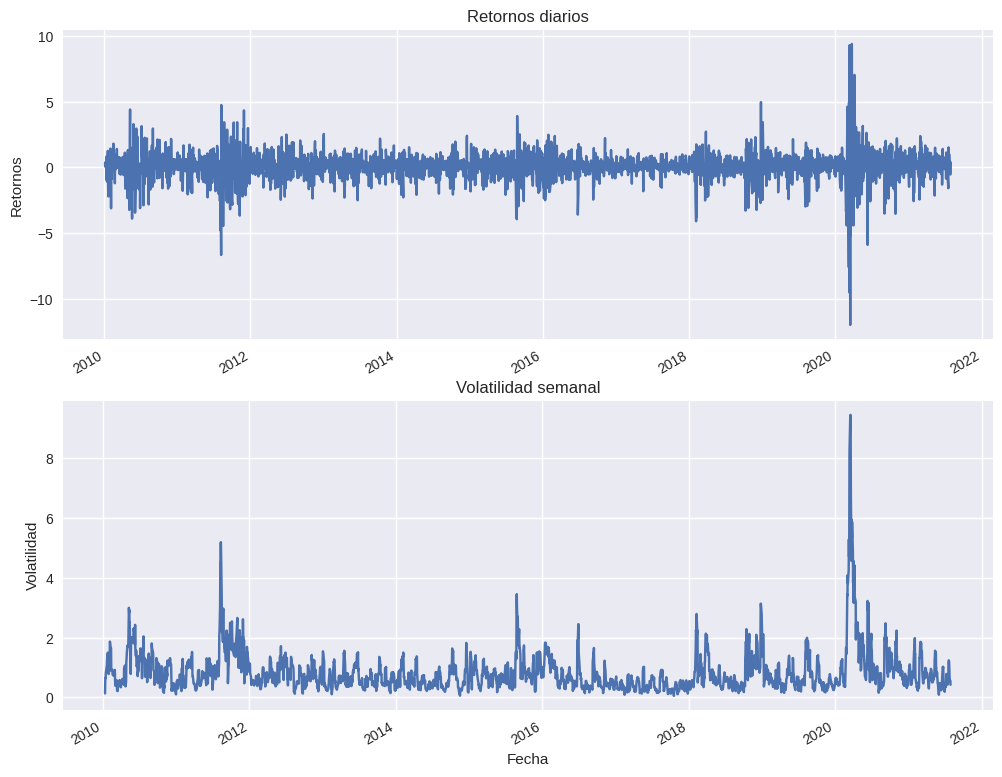

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,10))
ret.plot(title='Retornos diarios',
         xlabel='',
         ylabel='Retornos',
         ax=ax[0])

vol_realizada.plot(title='Volatilidad semanal',
                   xlabel='Fecha',
                   ylabel='Volatilidad',
                   ax=ax[1])
plt.show()

## Frontera de pronostico

In [ ]:
n = 252
split_date = ret[-n:].index

## ARCH(p)

$\sigma^2_t = w + ∑^p_{k=1} α_k(r_{t-k})^2$

In [ ]:
from numba import jit # Procesamiento en paralelo para disminuir el tiempo de procesamiento
from arch import arch_model
from sklearn.metrics import mean_squared_error as mse
import itertools

In [ ]:
arch =  arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4061.27
Distribution:                  Normal   AIC:                           8126.54
Method:            Maximum Likelihood   BIC:                           8138.50
                                        No. Observations:                 2913
Date:                Tue, Jul 04 2023   Df Residuals:                     2913
Time:                        22:31:10   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7014  5.002e-02     14.023  1.129e-44 [  0.603,  0.79

Eligiremos el criterio de informacion bayesiana (BIC) para seleccionar el modelo, es decir el hiperparametro $p$ (en este caso con los retrasos) que mejor BIC tenga

In [ ]:
bic_arch = []
for p in range(1,5):
  arch = arch_model(ret, mean='zero',
                    vol='ARCH',
                    p=p).fit(disp='off')
  bic_arch.append(arch.bic)
  if arch.bic == np.min(bic_arch):
    best_param = p

In [ ]:
arch = arch_model(ret,
                  mean='zero',
                  vol='ARCH',
                  p=best_param).fit(disp='off')
print(arch.summary)

<bound method ARCHModelResult.summary of                         Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3709.51
Distribution:                  Normal   AIC:                           7429.03
Method:            Maximum Likelihood   BIC:                           7458.91
                                        No. Observations:                 2913
Date:                Tue, Jul 04 2023   Df Residuals:                     2913
Time:                        22:31:10   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2794  

In [ ]:
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

In [ ]:
rmse_arch = np.sqrt(mse(vol_realizada[-n:]/100,
                        forecast_arch.variance.iloc[-n:]/100))
print(rmse_arch)

0.004603093625545652


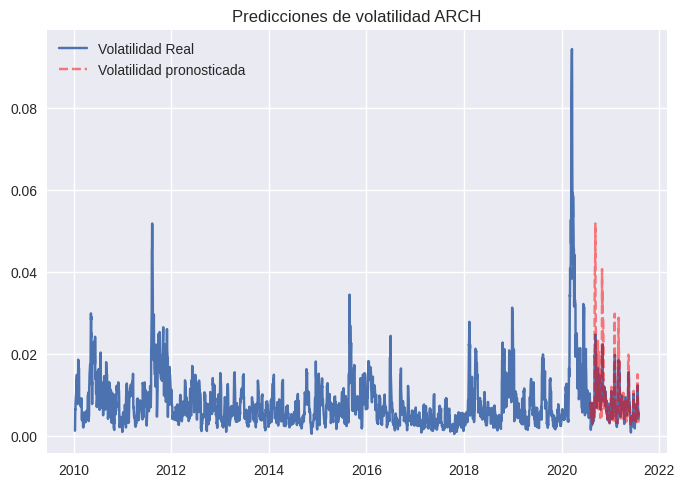

In [ ]:
plt.plot(vol_realizada/100, label='Volatilidad Real')
plt.plot(forecast_arch.variance.iloc[-n:]/100,
         label='Volatilidad pronosticada', color='red', ls='--', alpha=0.5)
plt.title('Predicciones de volatilidad ARCH')
plt.legend()
plt.show()

## GARCH

In [ ]:
garch = (
    arch_model(ret,
                   mean='zero',
                   vol='GARCH',
                   p=1, # AR(p)
                   o=0, # w
                   q=1) # MA(q)
    .fit(disp='off')
)
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Tue, Jul 04 2023   Df Residuals:                     2913
Time:                        22:31:11   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [ ]:
p = range(1,5)
q = range(1,5)
parametros = list(itertools.product(p,q))
bic_garch = []

for p,q in parametros:
  garch =  arch_model(ret,
                      mean='zero',
                      vol='GARCH',
                      p=p,
                      o=0,
                      q=q).fit(disp='off')
  bic_garch.append(garch.bic)
  if garch.bic == np.min(bic_garch):
    best_p = p
    best_q = q
    best_params = (p,q)


In [ ]:
garch = arch_model(ret,
                   mean='zero',
                   vol='GARCH',
                   p=best_p,
                   o=0,
                   q=best_q).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Tue, Jul 04 2023   Df Residuals:                     2913
Time:                        22:31:12   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [ ]:
forecast = garch.forecast(start=split_date[0])
garch_forecast = forecast

In [ ]:
rmse_garch = np.sqrt(mse(vol_realizada[-n:]/100,
                     garch_forecast.variance.iloc[-n:]/100))
rmse_garch

0.003265550551385009

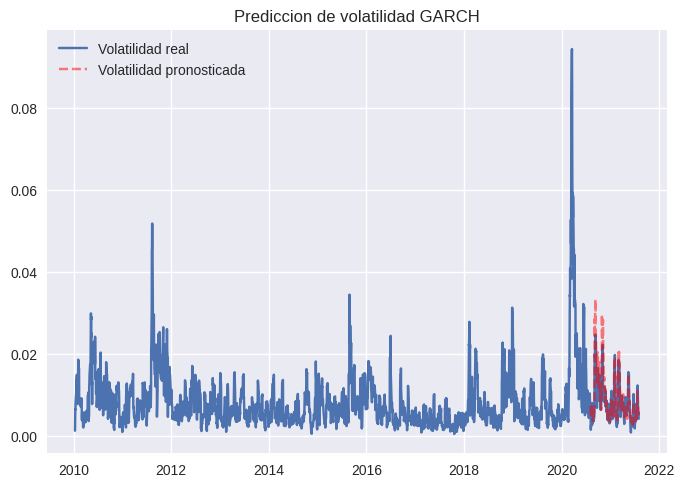

In [ ]:
plt.plot(vol_realizada/100, label='Volatilidad real')
plt.plot(garch_forecast.variance.iloc[-n:]/100,
         label='Volatilidad pronosticada',
         color='red',
         ls='--',
         alpha=0.5)
plt.title('Prediccion de volatilidad GARCH')
plt.legend()
plt.show()

## EGARCH

In [ ]:
bic_egarch = []
for p,q in parametros:
  egarch = arch_model(ret,
                      mean='zero',
                      vol='EGARCH',
                      p=p,
                      q=q).fit(disp='off')
  bic_egarch.append(egarch.bic)
  if egarch.bic == np.min(bic_egarch):
    best_p = p
    best_q = q
    best_params = (p,q)

In [ ]:
egarch = arch_model(ret,
                    mean='zero',
                    vol='EGARCH',
                    p=best_p,
                    q=best_q).fit(disp='off')
print(egarch.summary())

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3673.53
Distribution:                  Normal   AIC:                           7353.05
Method:            Maximum Likelihood   BIC:                           7370.98
                                        No. Observations:                 2913
Date:                Tue, Jul 04 2023   Df Residuals:                     2913
Time:                        22:31:14   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.4573e-03  6.769e-03      0.363      0.717 

In [ ]:
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

In [ ]:
rmse_egarch = np.sqrt(mse(vol_realizada[-n:]/100,
                          forecast_egarch.variance.iloc[-n:]/100))
rmse_egarch

0.0033175570711710205

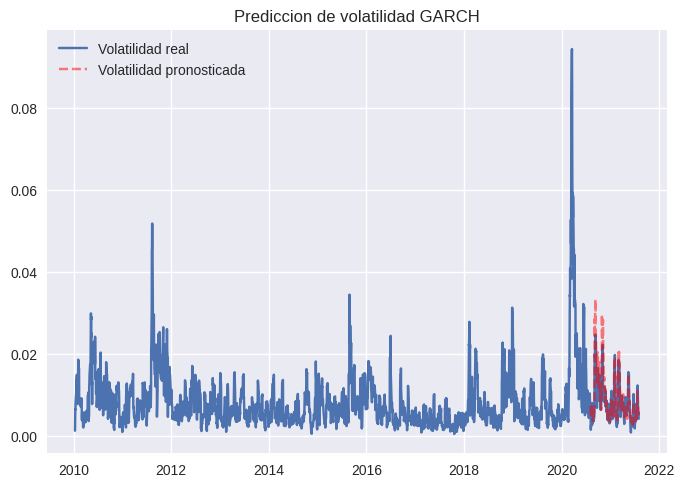

In [ ]:
plt.plot(vol_realizada/100, label='Volatilidad real')
plt.plot(garch_forecast.variance.iloc[-n:]/100,
         label='Volatilidad pronosticada',
         color='red',
         ls='--',
         alpha=0.5)
plt.title('Prediccion de volatilidad GARCH')
plt.legend()
plt.show()